# Set-up in Google Colab

In [ ]:
# Mount and install
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Quantum_Algorithms/SCA2025/QAOA_QUBO')

!pip install cudaq

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/MyDrive/Quantum_Algorithms/SCA2025/QAOA_QUBO/src_cudaq'

circuits.py  fourier.py  __init__.py  optimizer.py  __pycache__  qaoa_converter.py  utils.py


In [ ]:
# Reload
import importlib
import src_cudaq.utils, src_cudaq.qaoa_converter, src_cudaq.fourier, src_cudaq.circuits, src_cudaq.optimizer
importlib.reload(src_cudaq.utils)
importlib.reload(src_cudaq.qaoa_converter)
importlib.reload(src_cudaq.fourier)
importlib.reload(src_cudaq.circuits)
importlib.reload(src_cudaq.optimizer)

<module 'src_cudaq.optimizer' from '/content/drive/MyDrive/Quantum_Algorithms/SCA2025/QAOA_QUBO/src_cudaq/optimizer.py'>

# Requirements

In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Imports

In [ ]:
from src_cudaq.qaoa_converter import (
    Q_to_Ising,
    create_cost_Hamiltonian,
    create_mixer_Hamiltonian
)

from src_cudaq.fourier import (
    build_fourier_params,
    fourier_amplitude_init
)

from src_cudaq.circuits import (
    qaoa_fourier_kernel,
    cost_function_fourier,
    calculate_cost
)

from src_cudaq.optimizer import (
    run_qaoa_vqe
)

import numpy as np
import matplotlib.pyplot as plt
import cudaq
from cudaq import spin
from collections import defaultdict

# QUBO Problem

## QUBO Matrix Q
The QUBO matrix is given <a href = "https://www.actuaries.org.uk/system/files/field/document/assetliability-modelling-in-the-quantum-era.%20to%20use.pdf?"> here </a> as

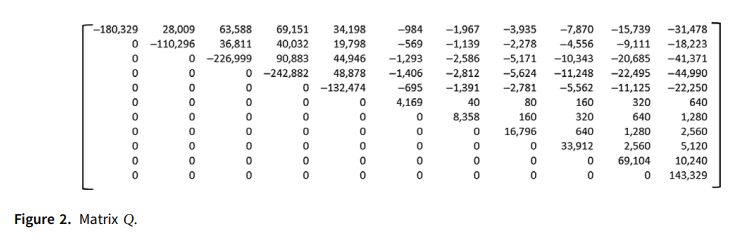

In [ ]:
Q = np.array([
    [-180329,  28009,   63588,   69151,   34198,   -984,   -1967,   -3935,   -7870,  -15739,  -31478],
    [      0, -110296,  36811,   40032,   19798,   -569,   -1139,   -2278,   -4556,   -9111,  -18223],
    [      0,       0, -226999,  90883,   44946,   -1293,  -2586,   -5171,  -10343,  -20685,  -41371],
    [      0,       0,       0, -242882,   48878,  -1406,  -2812,   -5624,  -11248,  -22495,  -44990],
    [      0,       0,       0,       0, -132474,   -695,  -1391,   -2781,   -5562,  -11125,  -22250],
    [      0,       0,       0,       0,       0,   4169,     40,      80,     160,     320,     640],
    [      0,       0,       0,       0,       0,       0,   8358,    160,     320,     640,    1280],
    [      0,       0,       0,       0,       0,       0,      0,  16796,     640,    1280,    2560],
    [      0,       0,       0,       0,       0,       0,      0,      0,   33912,    2560,    5120],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,   69104,   10240],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,       0,  143329]
])

depth=15
q=4 # Doesn't get much better
num_qubits = Q.shape[0]
num_restarts = 50
max_iterations = 250


# QAOA

In [ ]:
# --- QAOA Restarts ---
best_cost = np.inf
best_params = None
all_costs = []
all_params = []

for restart in range(num_restarts):
    print(f"\n🔹 Restart {restart + 1}/{num_restarts}")

    # Run VQE
    value, parameters = run_qaoa_vqe(
        depth=depth,
        q=q,
        Q=Q,
        num_qubits=num_qubits,
        max_iterations=max_iterations,
        seed=restart  # Different seed for each restart
    )

    print(f"🔻 Local minimum cost: {value}")

    all_costs.append(value)
    all_params.append(parameters)

    if value < best_cost:
        best_cost = value
        best_params = parameters

# --- Results ---
print(f"\n✅ Best cost found over {num_restarts} restarts: {best_cost}")
init_amps = build_fourier_params(
    fourier_amplitude_init(q), depth, q
)


print(init_amps)


🔹 Restart 1/50
🔻 Local minimum cost: -1.692180915161847

🔹 Restart 2/50
🔻 Local minimum cost: -1.8174572944443732

🔹 Restart 3/50
🔻 Local minimum cost: -1.7438744259253665

🔹 Restart 4/50
🔻 Local minimum cost: -1.820837717929077

🔹 Restart 5/50
🔻 Local minimum cost: -0.11488175249304135

🔹 Restart 6/50
🔻 Local minimum cost: -0.6194146003824217

🔹 Restart 7/50
🔻 Local minimum cost: -0.5821864538082959

🔹 Restart 8/50
🔻 Local minimum cost: -1.7520334311128762

🔹 Restart 9/50
🔻 Local minimum cost: -1.7115611494193466

🔹 Restart 10/50
🔻 Local minimum cost: -1.8236420072688317

🔹 Restart 11/50
🔻 Local minimum cost: -1.5262060062764642

🔹 Restart 12/50
🔻 Local minimum cost: -1.0946187947862498

🔹 Restart 13/50
🔻 Local minimum cost: -0.6539317115252727

🔹 Restart 14/50
🔻 Local minimum cost: -0.9840292066685415

🔹 Restart 15/50
🔻 Local minimum cost: -1.79897872316898

🔹 Restart 16/50
🔻 Local minimum cost: -0.0013373325490973296

🔹 Restart 17/50
🔻 Local minimum cost: -0.6152005754855169

🔹 Res

In [ ]:
# # --- Final probability distribution ---
# probs = qaoa_fourier_circuit(best_params)

# # Plot probability distribution
# plt.bar(range(2**num_qubits), probs)
# plt.xlabel("Qubit Configuration")
# plt.ylabel("Probability")
# plt.title("Diabatic QAOA Probability Distribution (Best Run)")
# plt.show()

# # --- Top configurations ---
# count = sum([1 for x in probs if x != 0])
# indices = np.where(probs >= nth_largest(probs, count))[0]
# indices = indices[np.argsort(probs[indices])[::-1]]
# binary_indices = [np.binary_repr(i, width=num_qubits) for i in indices]
# costs = np.array([calculate_cost(b, Q) for b in binary_indices])

# threshold = -nth_largest(-costs, 3)
# final_mask = costs <= threshold

# final_indices = np.array(binary_indices)[final_mask]
# final_costs = costs[final_mask]
# final_probs = probs[indices[final_mask].astype(int)]

# for config, cost, prob in zip(final_indices, final_costs, final_probs):
#     print(f"config: {config}, cost: {cost}, prob: {100*prob:.8f}%")

# total_prob = 0
# for index, prob in enumerate(probs):
#     if check_first_five_bits(index):
#         total_prob += prob
# print(f"The probability to get the correct value is: {100 * total_prob}%")

# # --- Five-bit grouping ---
# five_bits_probs = defaultdict(float)

# for index, prob in enumerate(probs):
#     group = index // 2**(num_qubits - 5)
#     five_bits_probs[group] += prob

# plt.plot(five_bits_probs.keys(), five_bits_probs.values())
# plt.xlabel("Five-bit Group")
# plt.ylabel("Total Probability")
# plt.title("Probability Distribution Over First Five Bits")
# plt.show()

# values_list = list(five_bits_probs.values())
# max_index = values_list.index(max(values_list))
# max_key = list(five_bits_probs.keys())[max_index]

# print(f"The probability to get the correct minimum: {100 * five_bits_probs[30]}%")
# print(f"The most probable value is at {np.binary_repr(max_key)} with the probability of {100 * five_bits_probs[max_key]}%")
